In [ ]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
all_files = glob.glob("../data/raw/311/*.csv")

df_list = []
for file in sorted(all_files):
    df_temp = pd.read_csv(file)
    df_list.append(df_temp)

df_911 = pd.concat(df_list, ignore_index=True)

df_911["created_date"] = pd.to_datetime(df_911["created_date"])
df_911["date"] = df_911["created_date"].dt.date

daily_311 = (
    df_911.groupby("date")
    .agg({"unique_key": "count"})
    .rename(columns={"unique_key": "total_complaints"})
    .reset_index()
)

df_weather = pd.read_csv("../data/raw/weather/weather_nyc_2023-01-01_to_2024-12-31.csv")
df_weather["date"] = pd.to_datetime(df_weather["date"]).dt.date

df = daily_311.merge(df_weather, on="date", how="inner")

print(f"\nCombined dataset: {df.shape}")
df.head()



Combined dataset: (731, 10)


,date,total_complaints,temperature_2m_mean,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,windspeed_10m_max,weathercode
0,2023-01-01,6209,8.785417,11.95,4.95,1.1,1.1,0.0,17.399586,55.0
1,2023-01-02,6680,7.981249,12.85,4.55,0.6,0.6,0.0,9.000000,51.0
2,2023-01-03,8255,9.691669,12.85,6.30,9.4,9.4,0.0,19.373219,63.0
3,2023-01-04,8462,13.081250,18.00,9.55,2.3,2.3,0.0,18.218275,53.0
4,2023-01-05,8414,9.912500,13.15,7.45,0.0,0.0,0.0,12.074766,3.0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 731 non-null    object 
 1   total_complaints     731 non-null    int64  
 2   temperature_2m_mean  731 non-null    float64
 3   temperature_2m_max   731 non-null    float64
 4   temperature_2m_min   731 non-null    float64
 5   precipitation_sum    731 non-null    float64
 6   rain_sum             731 non-null    float64
 7   snowfall_sum         731 non-null    float64
 8   windspeed_10m_max    731 non-null    float64
 9   weathercode          731 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 57.2+ KB


In [52]:
df.isnull().sum()

date                   0
total_complaints       0
temperature_2m_mean    0
temperature_2m_max     0
temperature_2m_min     0
precipitation_sum      0
rain_sum               0
snowfall_sum           0
windspeed_10m_max      0
weathercode            0
dtype: int64

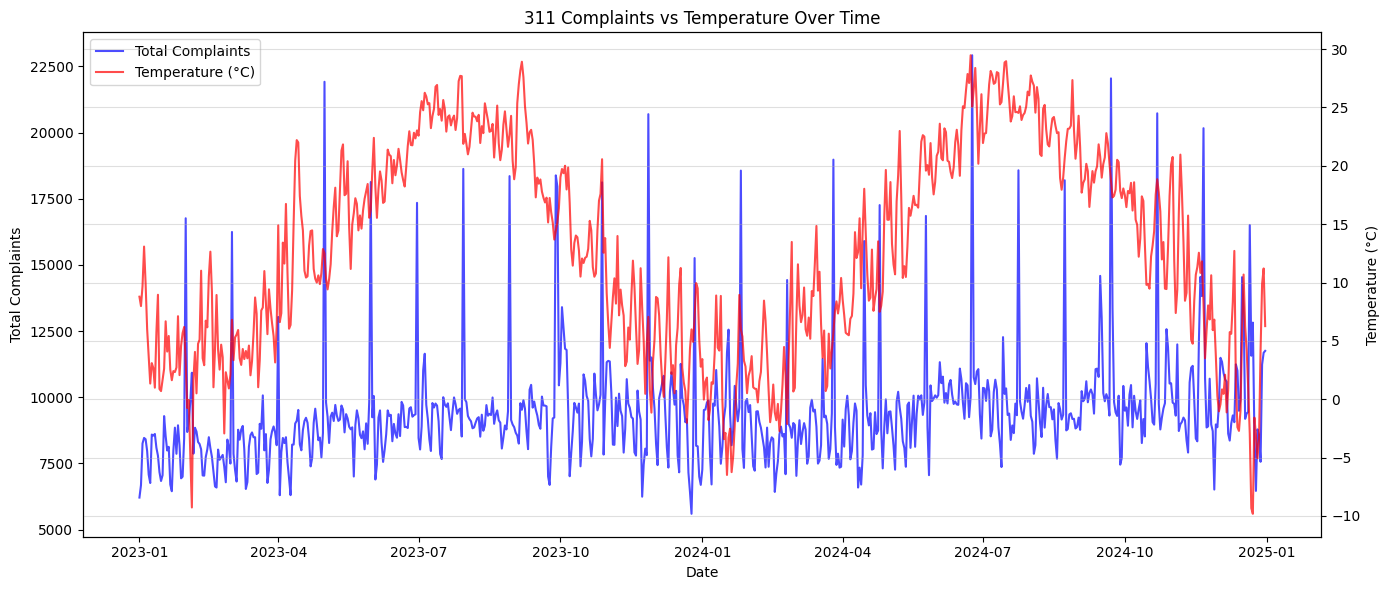

In [53]:
fig, ax1 = plt.subplots(figsize=(14, 6))

l1 = ax1.plot(df["date"], df["total_complaints"], c="b", alpha=0.7, label="Total Complaints")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Complaints")

ax2 = ax1.twinx()
l2 = ax2.plot(df["date"], df["temperature_2m_mean"], c="r", alpha=0.7, label="Temperature (°C)")
ax2.set_ylabel("Temperature (°C)")

ax1.legend([l1[0], l2[0]], [l1[0].get_label(), l2[0].get_label()], loc='upper left')

plt.title("311 Complaints vs Temperature Over Time")
plt.tight_layout()
plt.grid(alpha=0.4)
plt.show()

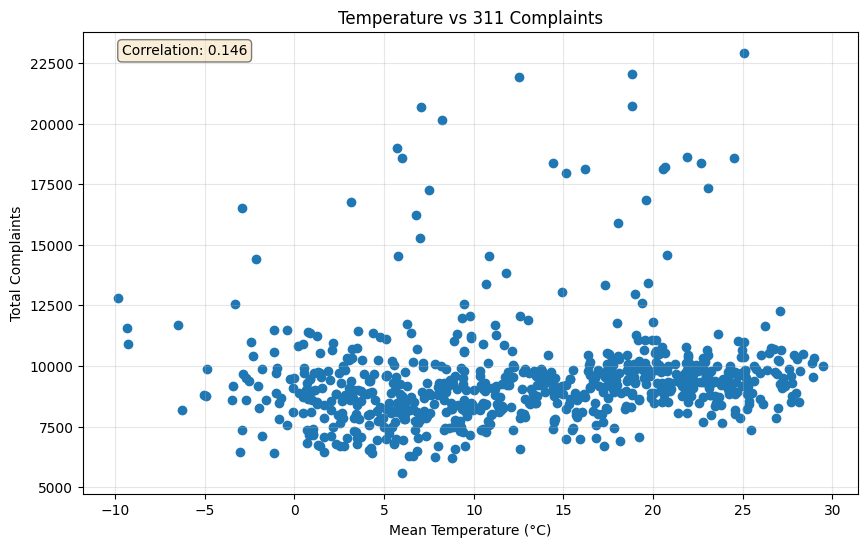

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(df["temperature_2m_mean"], df["total_complaints"])
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Total Complaints")
plt.title("Temperature vs 311 Complaints")

corr = df["temperature_2m_mean"].corr(df["total_complaints"])
plt.text(
    0.05,
    0.95,
    f"Correlation: {corr:.3f}",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.grid(alpha=0.3)
plt.show()

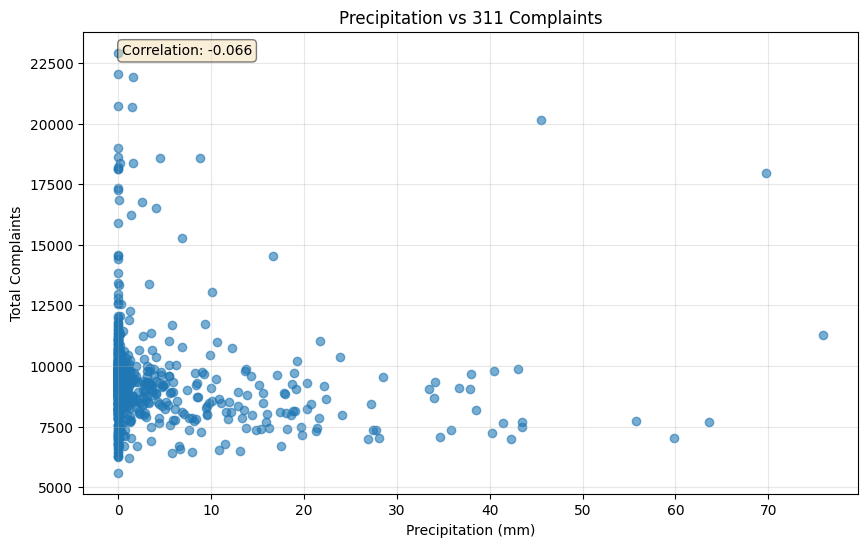

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(df["precipitation_sum"], df["total_complaints"], alpha=0.6)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Total Complaints")
plt.title("Precipitation vs 311 Complaints")

corr = df["precipitation_sum"].corr(df["total_complaints"])
plt.text(
    0.05,
    0.95,
    f"Correlation: {corr:.3f}",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.grid(alpha=0.3)
plt.show()

Complaints on Rainy vs Non-Rainy Days:
          count         mean          std     min     25%     50%       75%  \
is_rainy                                                                      
False     374.0  9635.024064  2142.739002  5596.0  8661.0  9382.0  10055.25   
True      357.0  9235.350140  2104.042629  6209.0  8116.0  8933.0   9703.00   

              max  
is_rainy           
False     22920.0  
True      21918.0  


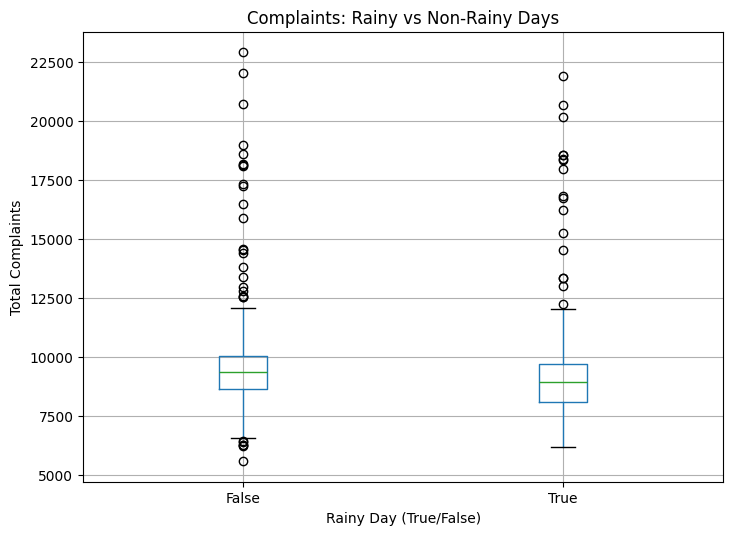

In [56]:
df["is_rainy"] = df["rain_sum"] > 0

print("Complaints on Rainy vs Non-Rainy Days:")
print(df.groupby("is_rainy")["total_complaints"].describe())

df.boxplot(column="total_complaints", by="is_rainy", figsize=(8, 6))
plt.xlabel("Rainy Day (True/False)")
plt.ylabel("Total Complaints")
plt.title("Complaints: Rainy vs Non-Rainy Days")
plt.suptitle("")
plt.show()

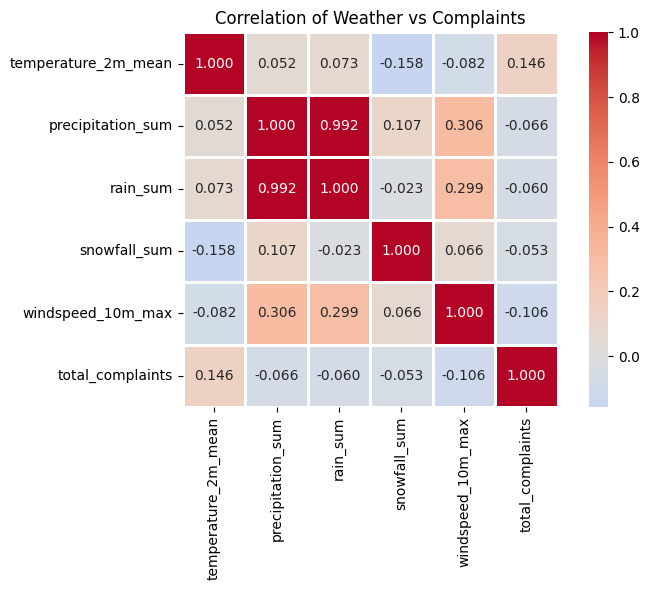

In [57]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'rain_sum',
                'snowfall_sum', 'windspeed_10m_max', 'total_complaints']

corr_matrix = df[weather_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation of Weather vs Complaints')
plt.tight_layout()
plt.show()


In [58]:
df.to_csv('../data/processed/311_weather_combined.csv', index=False)